**TELCO FINAL REPORT**

    The goal of this project is to find drivers of churn and produce prediction models in order to provide actionable data to Telco Management.

    The ML models herein are developed using SKLEARN and PANDAS to predict churn.

    The final report is assembled in final_report.ipynb.

    From past analysis without ML modeling it was discovered there is a high correlation between payment method and churn. This correlation and many others will be tested via the modeling to see if payment type is the best predictor or if other features make for a better model.

In [39]:
# here I import all relevant modules
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import prepare
import acquire
import scipy.stats as stats
from matplotlib import style
style.use('ggplot')
import itertools

**ACQUIRE/PREP.**

    It is worth noting that prepare.py relies on acquire.py to pull in the data which it preps. Also of note, prep removes 11 values in which have no total charges, these rows also have 0 tenure months. becuase the number of these rows is so small in comparison and they havent had a chance to churn. I feel comfortable removing them from the dataset.

In [3]:
# this function call acquires and preps in one motion, worth noting that 
# acquire.get_telco_data() is called within prepare.prep_telco() and will save a .csv of the 
# raw data
telco = prepare.prep_telco()
#look at the data
telco.head(3)

,is_female,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,1,0,1,1,9,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1
1,0,0,0,0,9,1,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
2,0,0,0,0,4,1,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0


**Prep additional info**

    in the prepare.py module, prep_telco() adds an autopay column, 1 has autopay, 0 does not, it then drops: "payment_type_id", "internet_service_type_id",     "contract_type_id","customer_id". 
    "total charges is converted from string to float, 'no's become 0's 'yes' become 1, 'female' become 1 and 'male' 0
    and a few dummy columns are made, drop_first=False in order to preserve human readability but could easily be set to True to assist the ML models

**EXPLORE**

    Below you will see some statistical analysis, some visualizations and correlation between churn and all features
    "Who churns and why?"

In [5]:
# get basic info
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   is_female                               7032 non-null   int64  
 1   senior_citizen                          7032 non-null   int64  
 2   partner                                 7032 non-null   int64  
 3   dependents                              7032 non-null   int64  
 4   tenure                                  7032 non-null   int64  
 5   phone_service                           7032 non-null   int64  
 6   multiple_lines                          7032 non-null   int64  
 7   online_security                         7032 non-null   int64  
 8   online_backup                           7032 non-null   int64  
 9   device_protection                       7032 non-null   int64  
 10  tech_support                            7032 non-null   int6

Lets split the data to avoid potential overfitting and to reserve some data for validating and testing

In [6]:
# split the data into train test validate
# this uses a function within the prepare.py module
x_train, y_train, x_validate, y_validate, x_test, y_test, train, validate, test= prepare.split_data(telco,"churn")
x_train.head(3)

,is_female,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
1947,1,0,1,1,37,1,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
6613,1,0,0,0,69,1,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
6256,1,0,0,0,72,1,1,0,1,1,...,0,0,1,0,1,0,1,0,0,0


In [8]:
#quick glance at correlations storing all and displaying the top ten
#absolute value to show strength wether positive or negative, all of x_train correlated with 'churn'
correlations = pd.DataFrame(abs(x_train.corrwith(train.churn))).reset_index()
#reset column names to make it more readable
correlations = correlations.rename(columns={'index': 'feature',0:"corr_value"})
#sort by value from highest to lowest, and display the top ten
correlations.sort_values('corr_value',ascending=False).head(10)

,feature,corr_value
17,contract_type_Month-to-month,0.407846
4,tenure,0.360733
25,payment_type_Electronic check,0.327841
21,internet_service_type_Fiber optic,0.309845
19,contract_type_Two year,0.300538
16,autopay,0.235577
22,internet_service_type_None,0.230359
15,total_charges,0.205416
14,monthly_charges,0.197832
18,contract_type_One year,0.184594


**Question 1**
    
    Does the month to month contract type affect churn?
    
Lets test this hypothesis

$H_0$ : There is no association between month to month contract and churn

$H_A$ : There is a association between month to month contract and churn

In [9]:
#make a cross tab
m_2_m_churn_cross = pd.crosstab(train['contract_type_Month-to-month'],train['churn'])
#check chi2 
chi2, p, degf, expected = stats.chi2_contingency(m_2_m_churn_cross)
#print results
print('Observed')
print(m_2_m_churn_cross.values)
print('---\nExpected')
print(expected.astype(int))
print('---')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
print('fail to reject null')

Observed
[[1642  114]
 [1249  932]]
---
Expected
[[1289  466]
 [1601  579]]
---
chi^2 = 653.0183
p     = 0.0000
fail to reject null


~~$H_0$ : There is no association between month to month contract and churn~~

**$H_A$ : There is an association between month to month contract and churn**

The p value is very low, assume a confidence interval of .95 or even .999, the p is so low its effectively zero, therefore the likelyhood of this correlation beign chance is null. 
There is a high level of certainty that the two are associated

**Month to Month contract type effects churn**

In [10]:
# calc average churn for all of train
average_churn = train.churn
# calc average churn for subset with month to month contracts
month_to_month_churn = train[train['contract_type_Month-to-month']==1].churn
print(f'Average churn is: {average_churn.mean():.2f}\nMonth to month churn is {month_to_month_churn.mean():.2f}')

Average churn is: 0.27
Month to month churn is 0.43


**Question 2**
    
    Does the amount of monthly charges affect churn? (do people with higher monthly charges churn more?)

$H_0$ : There is not a linear correlation between monthly charges and churn

$H_A$ : There is a linear correlation between monthly charges and churn

[Text(0.5, 1.0, 'Monthly Charges vs. Churn')]

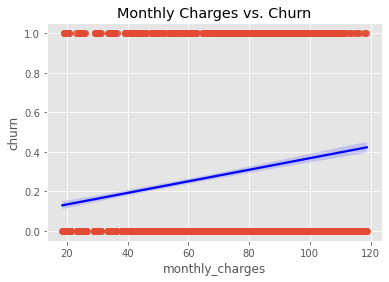

In [11]:
#quick graph to show the relation
p = sns.regplot(data = train, x = 'monthly_charges', y = 'churn', line_kws={"color": "blue"})
p.set(title='Monthly Charges vs. Churn')


In [12]:
#stats to show and test the hypothesis
r, p = stats.pearsonr(train.monthly_charges, train.churn)
r, p/2
# $H_0$ : There is not a linear correlation between monthly charges and churn
# $H_A$ : There is a linear correlation between monthly charges and churn
# There is a linear correlation between monthly charges and churn

(0.19783208219099263, 2.457056647107511e-36)

~~$H_0$ : There is not a linear correlation between monthly charges and churn~~

**$H_A$ : There is a linear correlation between monthly charges and churn**

In other words, those with higher monthly charges are more likely to churn

**Question 3**

    When does churn most occur? Low tenure? high tenure?

[Text(0.5, 1.0, 'Tenure vs. Churn')]

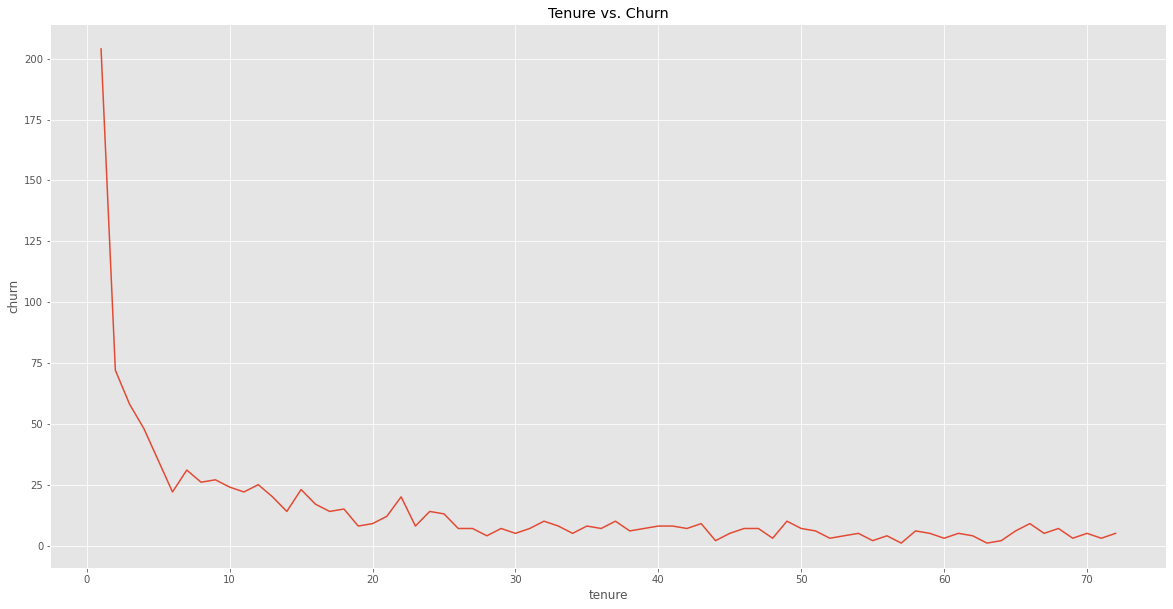

In [13]:
#make it large to see more easily
plt.figure(figsize=[20,10])
#pull the relevant columns, group by tenure month, and count number of people churned by month
subset =train[['churn','tenure']].groupby(['tenure']).sum().reset_index()
#give seaborn the data for a lineplot
p = sns.lineplot(data= subset, x = 'tenure', y = 'churn')
p.set(title='Tenure vs. Churn')

The majority of customer churn very early, it gets more steady after about month 7. Worth noting 50% of costumer who churn, do so before month 11

We can also look at each month and see which percent of customer churned for that month.

[Text(0.5, 1.0, 'Tenure vs. %Churn')]

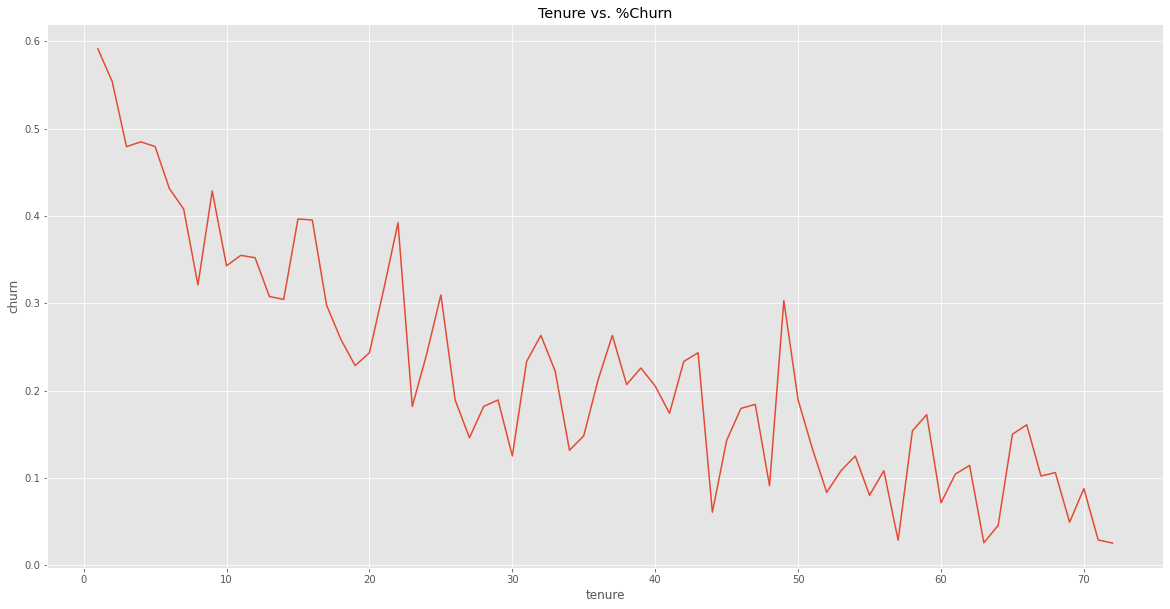

In [14]:
plt.figure(figsize=[20,10])
#similar to about but get the mean instead of sum to show % of those who churned that month
subset =train[['churn','tenure']].groupby(['tenure']).mean().reset_index()
#y = train[['churn','tenure']].groupby(['tenure']).sum().index.tolist()
p = sns.lineplot(data= subset, x = 'tenure', y = 'churn')
p.set(title='Tenure vs. %Churn')

As you can see our focus is probably better spent looking at people with short tenure. In my telco_work.ipynb I explored the full dataset more and found much more useful data in the short tenure subset. 


**Question 4**

    How early do see 50% of churn occur?

In [15]:
# calculate total number of churn
total_churn = train.churn.sum()
# lets look at the first year
for month in range(12):
    #keep a count of churn
    churn_so_far = train[train.tenure<=month].churn.sum()
    #calculate percent
    percent_of_churn = (churn_so_far/total_churn)*100
    # print results
    print(f'{churn_so_far} customers have churned before month {month+1}')
    print(f'that is {percent_of_churn:.2f}% of total churn')

0 customers have churned before month 1
that is 0.00% of total churn
204 customers have churned before month 2
that is 19.50% of total churn
276 customers have churned before month 3
that is 26.39% of total churn
334 customers have churned before month 4
that is 31.93% of total churn
382 customers have churned before month 5
that is 36.52% of total churn
417 customers have churned before month 6
that is 39.87% of total churn
439 customers have churned before month 7
that is 41.97% of total churn
470 customers have churned before month 8
that is 44.93% of total churn
496 customers have churned before month 9
that is 47.42% of total churn
523 customers have churned before month 10
that is 50.00% of total churn
547 customers have churned before month 11
that is 52.29% of total churn
569 customers have churned before month 12
that is 54.40% of total churn


%50 of churn is before month 10

**We will now focus on tenure of less than 11 months or (tenure <= 10)**

In [16]:
# split the data into train test validate for telco where tenure < 11
short_x_train, short_y_train, short_x_validate, short_y_validate, short_x_test, short_y_test, short_train, short_validate, test= prepare.split_data(telco[telco.tenure<11],"churn")
# get a new list of top features
short_top_features = abs(short_x_train.corrwith(short_train.churn)).sort_values(ascending=False).nlargest(n=10).index.tolist()
short_top_features

['internet_service_type_Fiber optic',
 'monthly_charges',
 'internet_service_type_None',
 'payment_type_Mailed check',
 'payment_type_Electronic check',
 'paperless_billing',
 'contract_type_Month-to-month',
 'multiple_lines',
 'streaming_movies',
 'streaming_tv']

Now we have a short tenure subset split for train test validate

Lets look at one actionable driver of churn, Monthly Charges

[Text(0.5, 1.0, 'Monthly Charges vs. churn')]

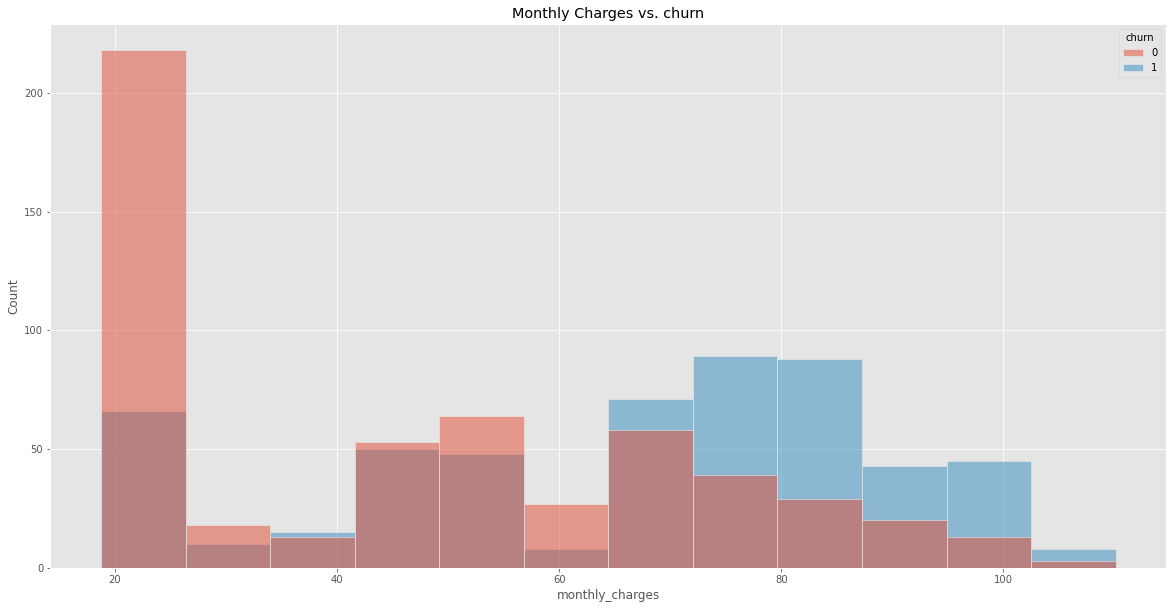

In [18]:
#overview of monthly charges and the amount of people churning
plt.figure(figsize=[20,10])
# using the short tenure subset
p= sns.histplot(data=short_train, x = short_train.monthly_charges, hue="churn")
p.set(title='Monthly Charges vs. churn')

Is there a correlation between churn and Autopay?

Text(0, 0.5, 'Percent Churned')

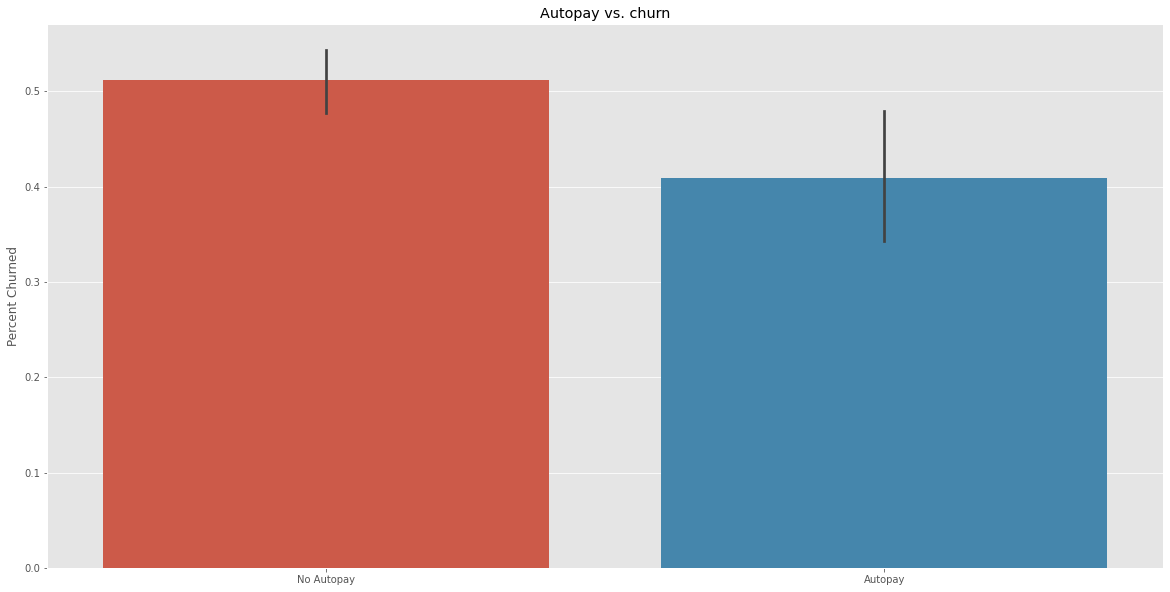

In [21]:
plt.figure(figsize=[20,10])
first_ten_months = train[train.tenure<11]
p= sns.barplot(data=first_ten_months, y = 'churn', x = 'autopay')
p.set(title='Autopay vs. churn')
p.set_xticklabels(['No Autopay','Autopay'])
p.set_xlabel('')
p.set_ylabel('Percent Churned')

**EXPLORE SUMMARY**

1. Short tenure is more relavant than the whole model. This is explored more in my working notebook where I go on to try 1000's of models and do further analysis.

2. Autopay and monthly charges affect churn rate.

3. 50% of customers churn before the 11th month. Not quite following the pareto principle (80/20 rule). but close enought to borrow the concept.

**MODELING**

    Here I will make some different types of models using the training dataset before evaluating them against each other using the validate dataset

Lets get a baseline using mode. AKA if we just assume everyone does what is most common, not churning, how accurate would that model be?

In [23]:
# lets establish a baseline to see if the model is even worth exploring
# the mode is the most common value, in this case we will see if its churn(1) or no churn(0)
baseline = short_y_train.mode().values[0]
baseline
#no churn is mode
# if we estimate everyone to not churn, we get the below accuracy
# therefore we should look for models with a better accuracy 0.73,
# it is also worth noting that accuracy is the goal versus precision or recall.
# We will not use precision becuase it doesnt factor negative cases
# we will not use recall for the similar reason, we dont want to put too much 
# emphasis on people who wont churn, nor on people who will churn
short_baseline_accuracy = (short_y_train == baseline).mean()
print( f'baseline_accuracy accuracy using mode is: {short_baseline_accuracy:.02f}')

baseline_accuracy accuracy using mode is: 0.51


We now have standard of .51 for our models to beat to even be considered.

We shall evaulate our models based on accuracy because we are concerned with all outcomes, false negatives are potential lost customer, false positives are potenial lost resources.

Model 1: I will use logistic regression with a variety of feature combinations and solvers, keeping the best model information

In [24]:
# repeat the best model search but on a subset of data where tenure <11
results7 = pd.DataFrame()
# lets look at different solvers instead of c
solvers = {'newton-cg', 'lbfgs', 'liblinear', 'sag','saga'}
# lets track top features by making an empty array and dummy score
# each model will compare to current best and set itself as best if higher
best_features =[]
best_score = 0
#make a list of all combinations of features
combinations = []
for i in range(1, len(short_top_features)+1):
    combinations.extend(list(itertools.combinations(short_top_features,i)))
#iterate between 1 and all top features
for combination in combinations:
    #adjust the c
    for solver in solvers:
        #build
        model = LogisticRegression(random_state=42, solver=solver)
        #convert list to array to pass into function
        features = np.array(combination)
        #fit on the combination determined above
        model.fit(short_x_train[features], short_y_train)
        #eval
        train_accuracy = model.score(short_x_train[features],short_y_train)
        validate_accuracy = model.score(short_x_validate[features],short_y_validate)
        delta_train_validate = abs(train_accuracy-validate_accuracy)
        #build df
        stats = pd.Series({"solver": solver,
            "number_features": len(features),
            "train_accuracy": train_accuracy,
            "validate_accuracy": validate_accuracy,
            "accuracy_difference":delta_train_validate})
        results7 = pd.concat([results7,stats],axis =1)
        # this could be done in the df but its a large output, array of up to len(best_features) strings
        # strings could be converted to index values to be more concise
        if validate_accuracy > best_score:
            #reset best
            best_score = validate_accuracy
            #save best features
            best_features = features

# transpose and reset the index to make it cleaner
results7 = results7.T.reset_index(drop=True)

In [25]:
#which feature made the best model
best_features

array(['internet_service_type_Fiber optic', 'monthly_charges',
       'internet_service_type_None', 'contract_type_Month-to-month',
       'multiple_lines', 'streaming_movies', 'streaming_tv'], dtype='<U33')

In [26]:
#lets look at the top models by train accuracy
results7.sort_values(by=['train_accuracy'],ascending = False).head(3)

,solver,number_features,train_accuracy,validate_accuracy,accuracy_difference
5063,lbfgs,9,0.714416,0.687898,0.026518
4343,lbfgs,7,0.712591,0.694268,0.018324
4341,liblinear,7,0.712591,0.698514,0.014077


In [27]:
#lets look at the top models by validate accuracy
results7.sort_values(by=['validate_accuracy'],ascending = False).head(3)

,solver,number_features,train_accuracy,validate_accuracy,accuracy_difference
4406,liblinear,7,0.70073,0.719745,0.019015
4405,newton-cg,7,0.70073,0.719745,0.019015
4408,lbfgs,7,0.70073,0.719745,0.019015


Here I will use random forest modeling modifying depth and minimum leaf size

In [28]:
# random forest with short tenure
results8 = pd.DataFrame()
# for depth from 1 to 20
for depth in range(1,21):
    # try different number of min samples per leaf
    for min_sample_leaf in range(1,5):
        #build
        model = RandomForestClassifier(random_state=42, min_samples_leaf= min_sample_leaf, max_depth=depth)
        #fit
        model = model.fit(short_x_train, short_y_train)
        #eval
        train_accuracy = model.score(short_x_train,short_y_train)
        y_predictions = model.predict(short_x_train)
        validate_accuracy = model.score(short_x_validate,short_y_validate)
        delta_train_validate = abs(train_accuracy-validate_accuracy)
        #build df
        stats = pd.Series({"max_depth": depth,
            "min_samples_leaf": min_sample_leaf,
            "train_accuracy": train_accuracy,
            "validate_accuracy": validate_accuracy,
            "accuracy_difference":delta_train_validate})
        results8 = pd.concat([results8,stats],axis =1)
# transpose and reset the index to make it cleaner
results8 = results8.T.reset_index(drop=True)

In [31]:
# top three by train_accuracy
results8.iloc[results8.train_accuracy.nlargest(n=3).index]
# great accuracy on train, likely overfitting

,max_depth,min_samples_leaf,train_accuracy,validate_accuracy,accuracy_difference
56,15.0,1.0,0.993613,0.702760,0.290853
60,16.0,1.0,0.993613,0.698514,0.295099
64,17.0,1.0,0.993613,0.681529,0.312084


In [32]:
# top three by validate_accuracy
results8.iloc[results8.validate_accuracy.nlargest(n=3).index]
# decent accuracy on validate, several points higher than baseline

,max_depth,min_samples_leaf,train_accuracy,validate_accuracy,accuracy_difference
30,8.0,3.0,0.802920,0.719745,0.083174
41,11.0,2.0,0.887774,0.719745,0.168028
29,8.0,2.0,0.826642,0.715499,0.111143


Lets combine all the results and pull the top model

In [35]:
#combine all results involving short tenure dataset
short_tenure_results = results7.append(results8)
#sort by validate accuracy, then accuracy_difference, pull the top model, drop irrelvant columns
short_tenure_results.sort_values(by=['validate_accuracy','accuracy_difference'],ascending = [False, True]).head(1).dropna(axis=1)

,solver,number_features,train_accuracy,validate_accuracy,accuracy_difference
4405,newton-cg,7,0.70073,0.719745,0.019015


In [36]:
# recreate the model with same config
#best features comes from the results of above testing trying multiple variations of combinations
best_features = ['internet_service_type_Fiber optic', 'monthly_charges',
       'internet_service_type_None', 'contract_type_Month-to-month',
       'multiple_lines', 'streaming_movies', 'streaming_tv']
best_model = LogisticRegression(random_state=42, solver= 'newton-cg')        
#fit it as before
best_model = best_model.fit(short_x_train[best_features], short_y_train)
#eval
y_predictions = best_model.predict(short_x_train[best_features])
train_accuracy = best_model.score(short_x_train[best_features],short_y_train)
validate_accuracy = best_model.score(short_x_validate[best_features],short_y_validate)
test_accuracy = best_model.score(short_x_test[best_features],short_y_test)
#build df
stats = pd.Series({"baseline_accuracy":short_baseline_accuracy,
    "train_accuracy": train_accuracy,
    "validate_accuracy": validate_accuracy,
    "test_accuracy": test_accuracy})
stats

baseline_accuracy    0.506387
train_accuracy       0.700730
validate_accuracy    0.719745
test_accuracy        0.693878
dtype: float64

The best model for the short tenure subset has an almost 20% increase in accuracy on the test set than baseline, which is great, especially since 50% of all churn occurs in this timeline. This model provides more actionable data for the rest of Telcoco

**OUTPUT CSV**

    Here is the code for the predictions csv

In [43]:
# create predictions for the model's performance on the test set
y_pred = best_model.predict(short_x_test[best_features])

# establish the probability for those predictions created above and use the value for churn = 1
y_pred_proba = best_model.predict_proba(short_x_test[best_features])[:,1]

In [59]:
#new dataframe from test
predictions = test
# add the relevant columns
predictions['churn_probability'] = y_pred_proba
predictions['churn_prediction'] = y_pred
#keep those columns and the index
predictions = predictions[['churn_probability','churn_prediction']]
#take a look
predictions


,churn_probability,churn_prediction
4526,0.722575,1
2110,0.757981,1
3810,0.793623,1
3857,0.409039,0
6336,0.793045,1
...,...,...
2951,0.391742,0
757,0.067079,0
281,0.394828,0
720,0.674030,1


In [60]:
# add back in the customer if from the original data matched on index with an inner join
predictions = predictions.join(acquire.get_telco_data().customer_id, how="inner")
# set index to customer id
predictions = predictions.set_index('customer_id')
# take a look
predictions

Reading from csv...


,churn_probability,churn_prediction
customer_id,,
6376-GAHQE,0.722575,1
3027-ZTDHO,0.757981,1
5357-TZHPP,0.793623,1
5424-RLQLC,0.409039,0
8972-HJWNV,0.793045,1
...,...,...
4208-UFFGW,0.391742,0
1099-GODLO,0.067079,0
0415-MOSGF,0.394828,0


In [62]:
#save to csv
predictions.to_csv('predictions.csv')

**CONCLUSION**

    1. Most churn happens early
    2. Month to month customer churn most, those without autopay churn more than those without
    3. Focusing on newer customer is worthwhile because they are most likely to churn
    4. Our logistic regresion model should increase prediction of churn by roughly 20%

**RECOMMENDATIONS**

    1. Offer incentives to switch from month to month to one year or two year contracts
    2. Do the same for autopay
    3. Provide monthly discounts to those predicted to churn

**NEXT STEPS**

    1. Get more data from customer. Survey those churning ("why did you leave? Cost? service? etc?)
    2. Run more models, I ran only a few thousand models, with more time I couldnt increase this by a few orders of magnitude